# Temporal Difference Updating without a Learning Rate
Marcus Hutter, Shane Legg (NIPS 2008)

The authors derive an estimator for TD($\lambda$) that doesn't have a learning rate (or rather, the learning rate has an analytical expression).

## Approach
### Notations
Value function of the state $s$:

$$
\bar{V_s} = E\{r_k + \gamma r_{k+1} + \gamma^2 r_{k+2} + ... | s_k = s\}
$$


Empirical future discounted reward of a state $s_k$:

$$
v_k := \sum_{u=k}^{\infty} \gamma^{u-k}r_u
$$

Estimate of the value function of the state $s$ at time $t$:

$$
V_s^t
$$

### Derivation
> For each state $s$ we would like the estimate $V_s$ to be close to $v_k$ for all $k$ such that $s = s_k$.
> Furthermore, in non-stationary environments we would like to discount old evidence by some parameter $\lambda \in (0,1]$. Formally, we want to minimise the loss function,

$$
L := \frac{1}{2} \sum_{k=1}^t \lambda^{t-k}(v_k - V_{s_k}^t)^2
$$

Note that because of this cost, the choice of $\lambda$ means a lot about the stationarity of the environment. If we set $\lambda=1$, we expect the value functions to be stable over time. So the role of $\lambda$ is different than in regular TD($\lambda$) where it is some sort of knob to control the depth of backups. 

Set $\frac{dL}{dV_s^t} = 0$.

We get:

$$
V_s^t N_s^t = \sum_{k=1}^t \lambda^{t-k}\delta_{s_k s}v_k
$$

where $N_s^t$ is a discounted state visit counter: $N_s^t := \sum \lambda^{t-k} \delta{s_k s}$.

They split $v_k$ into 2 terms: sum of discounted observed rewards up to current timestep and the future discounted rewards.

$$
v_k = \sum_{u=k}^{t-1} \gamma^{u-k} r_u + \gamma^{t-k}v_t
$$

They recover:
$$
V_s^t N_s^t = R_s^t + E_s^t v_t
$$

where $E_s^t := \sum_{k=1}^{t-1} (\lambda \gamma)^{t-k} \delta{s_k s}$ is the eligility trace of state $s$ and $R_s^t := \sum_{u=1}^{t-1} \lambda^{t-u} E_s^u r_u$ is the discounted reward with eligibility.

We can then bootstrap by substituting the unknown $v_t$ with $V_{s_t}^t$ our estimate.

Next they show how one can compute the traces and discounted rewards incrementally (skipped here).

They obtain:

$$
V_s^{t+1} = V_s^t + E_s^t \beta_t(s,s_{t+1})(r_t + \gamma V_{s_{t+1}}^t - V_{s_t}^t)
$$

The learning rate is (for all $s$):

$$
\beta_t(s, s_{t+1}) := \frac{1}{N_{s_{t+1}}^t - \gamma E_{s_{t+1}}^t} \frac{N_{s_{t+1}}^t}{N_s^t} = \frac{K}{N_s^t}
$$


### Control
The authors adapt Q learning (Watkins') and Sarsa. Simply replace the learning rate with $beta_t$.

Sarsa is transformed into the following algorithm:
![HLS(lambda)](HLS.png)

Note that:
- $\gamma$ cannot be 1 because the denominator of the first term would be zero.
- In my experiments, K is often close to $1$. It is not much bigger than $10$. 
- One can see that there is potentially a lot of numerical instability if $N_s^t$ gets too small, which can be the case very easily if $\lambda$ is not close enough to $1$. For example, if you set $\lambda=0.5$ and don't see the state $s$ for $50$ timesteps (with no eligibility traces on $s$ too), then you'd get $\beta_t(s, s_{t+1}) = \frac{1}{\lambda^{10}} \approx 10^{15}$.


## Experiments
### Overview of the experiments and comments
The authors evaluate the method in prediction tasks on stationary and non-stationary MDPs.

To check if the performance gain doesn't only come from annealing the learning rate, they tried annealing with a learning rate $ \propto \frac{1}{\sqrt{t}} $ and $ \propto \frac{1}{\sqrt[3]{t}} $ but it doesn't match the performance of HL($\lambda$).

They didn't check with a learning rate $\propto \frac{1}{N(s,a)}$ though. This could be interested as the other factor in the $\beta$ term is often close to 1. It could mean that this term suffices.

For the non-stationary task, one criticism is that they actually know the "non-stationarity" level needed. Their grid search over $\lambda$ must be very very fine-grained as the optimal $\lambda$ is $0.9995$. So maybe a grid search over $\lambda$ and $\alpha$ that's coarser is cheaper than tuning HL($\lambda$) in that case.

There is also one experience (section 6) with a control task on the windy gridworld using HLS (Sarsa). They turn the task into a continuous task. It is justified possibly by the fact that $\gamma = 1$. It also seems coherent so that they can keep the counts $N_{s_t}$ accross episodes.

### More experiments
In the following, we evaluate the algorithm on episodic tasks. This is kind of wrong as the discounting rate cannot be set to $1$, so we always set it to $0.99$.

All the $Q$ estimates are initialized to $10$.

We only compare Sarsa($\lambda$) with eligibility traces with HLS($\lambda$) and not Q($\lambda$) vs the Q($\lambda$) variant.

In the roulette environment, HLS($\lambda$) outperforms Sarsa($\lambda$) for every possible choice of learning rate.

In the frozen lake environment and in the taxi environment, it is the opposite. I don't know why it is so. Maybe HLS is more sensitive to initialisation.

The roulette and frozen lake environment are both stochastic. The taxi environment is deterministic.

In [486]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import gym
import pickle
import glob
import re

re_alpha = re.compile('.+alpha-(\d\.\d)')
re_lambda = re.compile('.+lambda_-(\d\.\d)')
re_algo = re.compile('.+alg\-([a-z]+)\_$')

%matplotlib inline

"""
def moving_average(data, step):
    N = len(data) - step
    res = np.zeros(N)
    for i in range(N):
        res[i] = np.mean(data[i:i+step])
    return res
"""

def load_rewards_count(dirname):
    return pickle.load(open(dirname + "/rewards_count.p", "rb"))

def plot_grid_search(list_dirnames):
    stats = [load_rewards_count(dn) for dn in list_dirnames]
    n = 100
    plt.figure(figsize=(8,8))
    alpha, lambda_, score = [], [], []
    markers = {'sarsa': '+', 'hls': (5,2), 'expsarsa': 'o', 'q': 'v'}
    
    for i, j in enumerate(zip(list_dirnames, stats)):
        l, s = j
        algo = re_algo.match(l).group(1)
        alpha.append(float(re_alpha.match(l).group(1)))
        lambda_.append(re_lambda.match(l).group(1))
        score.append(s.mean())
        if algo == 'hls':
            color = 'black'
        else:
            color = (alpha[i], 0, 1-alpha[i])
        plt.scatter(lambda_[i], score[i], s=50, color=color, alpha=0.8, marker=markers[algo])
        #plt.fill_between(range(mean.shape[0]), mean-std, mean+std,
        #                alpha=0.2, edgecolor='black', facecolor='b',
        #                linewidth=1, linestyle='dashdot', antialiased=True)
        #plt.fill_between(range(mean.shape[0]), data.min(axis=0), data.max(axis=0),
        #                alpha=0.2, edgecolor='black', facecolor='y',
        #                linewidth=1, linestyle='dashdot', antialiased=True)
    plt.title("Mean reward over several episodes and 10 trials.\n* is HLS, + is Sarsa.\n"
              "Color indicates learning rates (blue is 0.1, red is 1)")
    plt.ylabel('Mean reward')
    plt.xlabel('Lambda')
    plt.show()

### Roulette-v0 with eps=0.1, 200 episodes, 30 trials

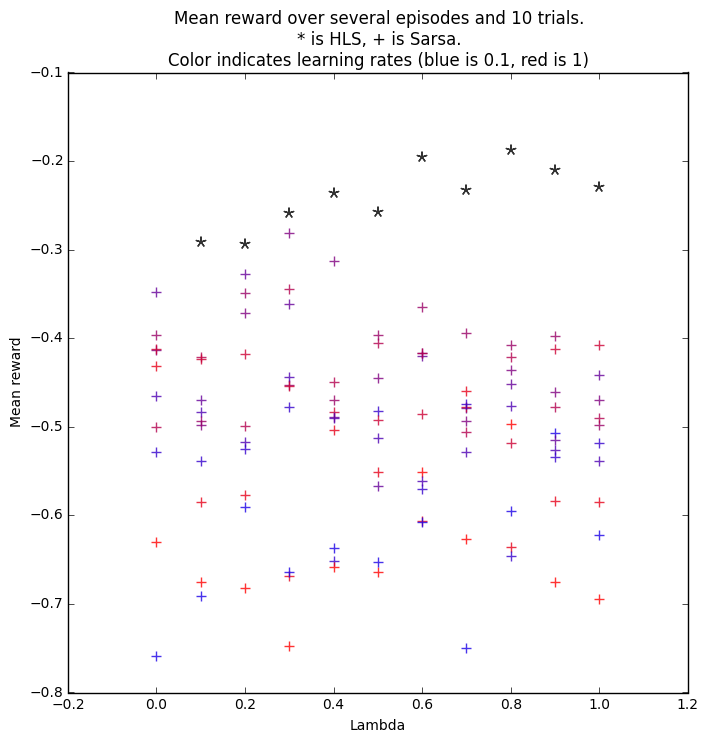

In [487]:
list_dir = glob.glob('roulette*eps-0.1*')
plot_grid_search(list_dir)

### Taxi-v1 with eps=0.1, 300 episodes, 10 trials

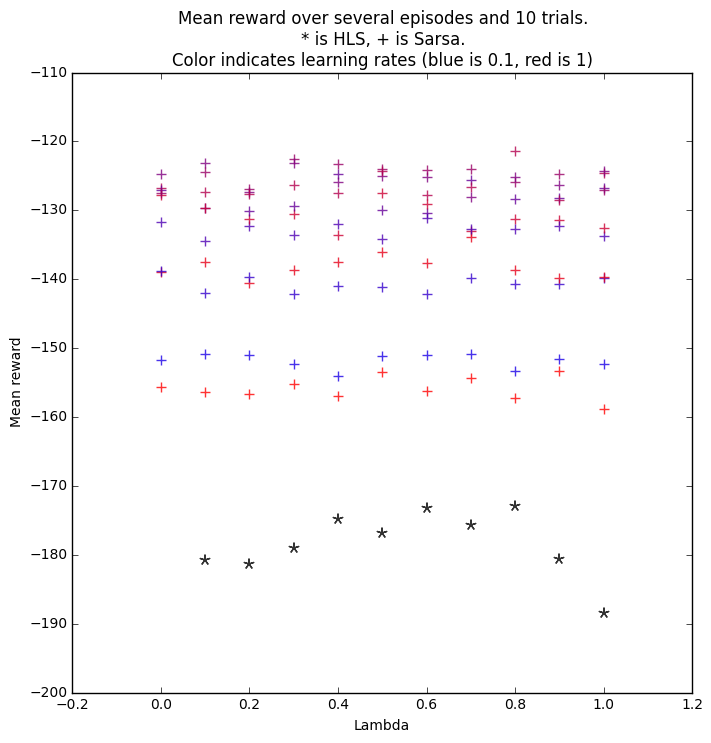

In [488]:
list_dir = glob.glob('taxi*eps-0.1*')
plot_grid_search(list_dir)

### FrozenLake-v0 with eps=0.1, 200 episodes, 30 trials

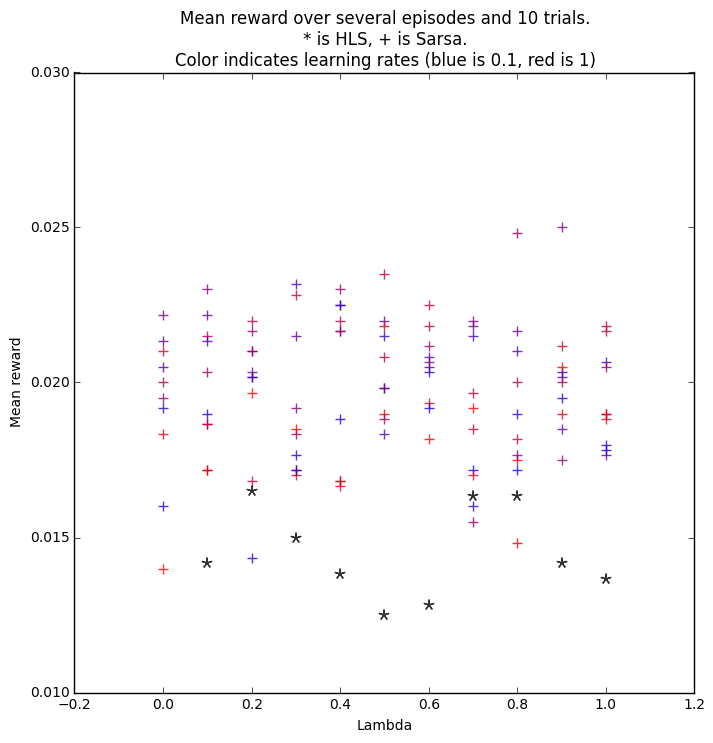

In [489]:
list_dir = glob.glob('frozenlake_*eps-0.1*')
plot_grid_search(list_dir)

# Conclusion
This paper is interesting because its goal is to get rid of an hyperparameter. This potentially saves a lot of computation as most algorithms are sensitive to their hyperparameters which are chosen using an expensive grid-search.

It is not clear why the algorithm underperforms on 2 of the 3 environments and why it is very effective on the last one. I should try on a windy grid world in the same settings as in the paper to check if everything is fine with my implementation. Then I could change part of the environment to see when things go wrong.

It could be also interesting to extend the algorithm to the function approximation case.